In [ ]:
# Librerie base
import numpy as np
import pandas as pd

# Visualizzazione
import matplotlib.pyplot as plt  
import seaborn as sns

# Modelli statistici
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm

# Libreria ISLP (Statistical Learning) — se non ti serve, puoi rimuoverla
from ISLP import load_data
from ISLP.models import ModelSpec as MS, summarize, poly


In [ ]:
# 1. Caricamento e prime informazioni
df = pd.read_csv("f1_pitstops_2018_2024.csv", encoding='utf-8')
print("=== Head del dataset ===")
print(df.head(), "\n")

print("=== Colonne ===")
print(df.columns.tolist(), "\n")

print("=== Info ===")
df.info()
print("\n=== Statistiche descrittive (numeriche) ===")
print(df.describe(), "\n")


=== Colonne con valori nulli ===
                         count    percent
Pit_Lap                   2810  38.106862
Track_Temp_C               373   5.058313
Date                       373   5.058313
Wind_Speed_KMH             373   5.058313
Humidity_%                 373   5.058313
Air_Temp_C                 373   5.058313
Country                    373   5.058313
Location                   373   5.058313
Time_of_race               373   5.058313
Race Name                  373   5.058313
Pit_Time                   281   3.810686
AvgPitStopTime             185   2.508815
Lap Time Variation         185   2.508815
Driver Aggression Score    185   2.508815
Fast Lap Attempts          185   2.508815
Stint Length               109   1.478167
Tire Compound              109   1.478167
Stint                      109   1.478167
Tire Usage Aggression       66   0.895037 



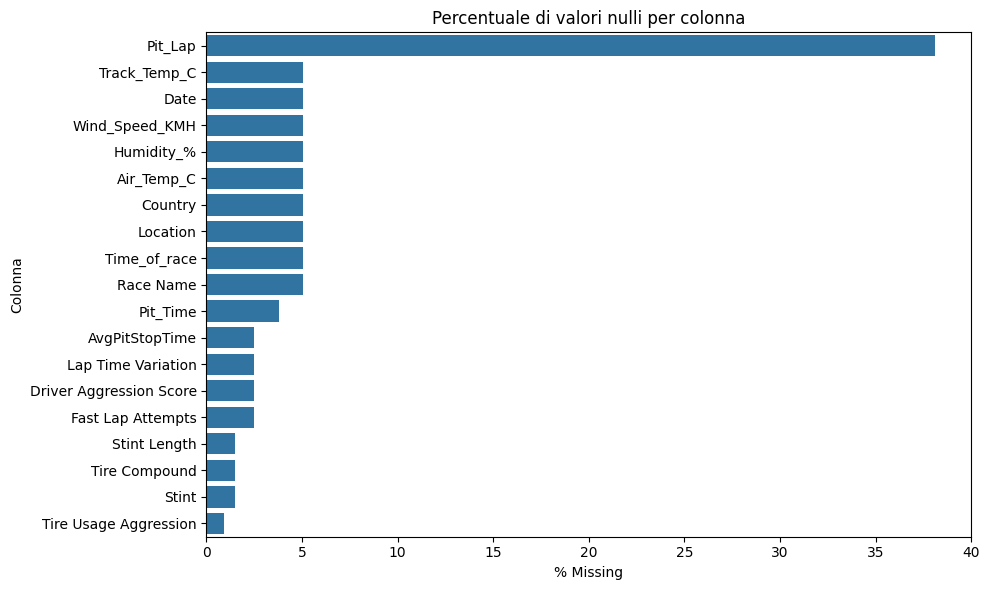

In [33]:
# 2. Missing values: conteggi e percentuali
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_pct    = (df.isnull().mean() * 100).sort_values(ascending=False)
missing_df     = pd.concat([missing_counts, missing_pct], axis=1, keys=['count','percent'])
missing_df = missing_df[missing_df['count'] > 0]
print("=== Colonne con valori nulli ===")
print(missing_df, "\n")

# Barplot dei missing
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_df['percent'], y=missing_df.index)
plt.title('Percentuale di valori nulli per colonna')
plt.xlabel('% Missing')
plt.ylabel('Colonna')
plt.tight_layout()
plt.show()


In [34]:
# 3. Pulizia: elimino colonne >30% missing e righe con qualsiasi NaN
cols_drop = missing_df[missing_df['percent'] > 30].index.tolist()
df_clean  = df.drop(columns=cols_drop).dropna(axis=0)
print(f"Rimosse colonne (>30% missing): {cols_drop}")
print(f"Dimensione dataset dopo pulizia: {df_clean.shape}\n")


Rimosse colonne (>30% missing): ['Pit_Lap']
Dimensione dataset dopo pulizia: (6732, 29)



In [ ]:
# 4. Heatmap di correlazione preliminare
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
if len(numeric_cols) >= 4:
    plt.figure(figsize=(12, 10))
    corr = df_clean[numeric_cols].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f',
                cmap='coolwarm', square=True, linewidths=.5,
                cbar_kws={"shrink": .75})
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print("Non ci sono abbastanza colonne numeriche per la heatmap.\n")


In [ ]:
# 5. Rimozione di feature altamente correlate (>0.99)
corr_abs = df_clean[numeric_cols].corr().abs()
upper    = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
to_drop  = [col for col in upper.columns if any(upper[col] > 0.99)]
# Escludo volutamente Driver Aggression Score dalla rimozione automatica 
to_drop = [c for c in to_drop if c != 'Driver Aggression Score']
# Aggiungo AvgPitStopTime per il ragionamento che usi Pit_Time come target
if 'AvgPitStopTime' in df_clean.columns:
    to_drop.append('AvgPitStopTime')

df_reduced = df_clean.drop(columns=to_drop)
print("Rimosse colonne per alta correlazione:", to_drop, "\n")


In [ ]:
# Heatmap dopo il drop
numeric_cols2 = df_reduced.select_dtypes(include=[np.number]).columns
if len(numeric_cols2) >= 4:
    plt.figure(figsize=(12, 10))
    corr2 = df_reduced[numeric_cols2].corr()
    mask2 = np.triu(np.ones_like(corr2, dtype=bool))
    sns.heatmap(corr2, mask=mask2, annot=True, fmt='.2f',
                cmap='coolwarm', square=True, linewidths=.5,
                cbar_kws={"shrink": .75})
    plt.title('Heatmap dopo rimozione feature altamente correlate')
    plt.tight_layout()
    plt.show()


In [ ]:
# 6. Scatter plot vs Driver Aggression Score
if 'Driver Aggression Score' in df_reduced.columns:
    x_vars = [c for c in numeric_cols2 if c != 'Driver Aggression Score']
    n = len(x_vars)
    if n > 0:
        fig, axes = plt.subplots(1, n, figsize=(5 * n, 5), sharey=True)
        for ax, var in zip(axes.flatten(), x_vars):
            sns.scatterplot(data=df_reduced, x=var, y='Driver Aggression Score', ax=ax)
            ax.set_title(f'{var} vs Aggression')
            ax.set_xlabel(var)
        axes[0].set_ylabel('Driver Aggression Score')
        plt.tight_layout()
        plt.show()
    else:
        print("Nessuna variabile numerica rimasta per scatterplot.\n")
else:
    print("'Driver Aggression Score' non è presente, salto scatterplot.\n")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleziono solo un sottoinsieme di variabili numeriche (per non intasare la matrice)
cols_subset = [
    'Pit_Time', 'Stint Length',
     'Driver Aggression Score'
]
sns.pairplot(df_reduced[cols_subset].dropna(), kind='reg', diag_kind='kde',
             plot_kws={'line_kws':{'color':'gray','alpha':0.5}})
plt.suptitle("Pairplot di alcune variabili numeriche", y=1.02)
plt.show()


In [ ]:
import numpy as np

# Matrice di correlazione assoluta
corr_abs = df_reduced.select_dtypes(include='number').corr().abs()

# Per ogni colonna, sommo le correlazioni con tutte le altre
score = corr_abs.sum().sort_values(ascending=False)

print("Somma delle correlazioni (assolute) per variabile:")
print(score)


Original – Range: 0.59–448.79, Skewness: 4.38, Kurtosis: 26.81
Log1p – Range: 0.46–6.11, Skewness: 2.14, Kurtosis: 3.14


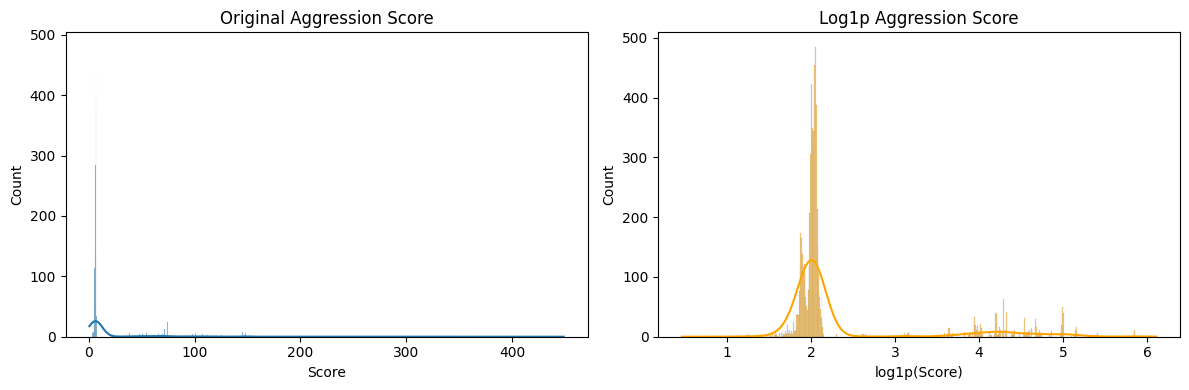

In [21]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# creazione della versione log-transform
df_reduced['log_Aggression'] = np.log1p(df_reduced['Driver Aggression Score'])

# separo le due serie
y_orig = df_reduced['Driver Aggression Score'].dropna()
y_log  = df_reduced['log_Aggression'].dropna()

# calcolo range, skewness e kurtosis per entrambe
for name, y in [('Original', y_orig), ('Log1p', y_log)]:
    print(f"{name} – Range: {y.min():.2f}–{y.max():.2f}, "
          f"Skewness: {stats.skew(y):.2f}, "
          f"Kurtosis: {stats.kurtosis(y):.2f}")

# plot affiancati
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(y_orig, kde=True, ax=axes[0])
axes[0].set_title("Original Aggression Score")
axes[0].set_xlabel("Score")

sns.histplot(y_log, kde=True, ax=axes[1], color='orange')
axes[1].set_title("Log1p Aggression Score")
axes[1].set_xlabel("log1p(Score)")

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# 1) Converti a numerico
df_reduced['Pit_Time']         = pd.to_numeric(df_reduced['Pit_Time'], errors='coerce')
df_reduced['TotalPitStops']    = pd.to_numeric(df_reduced['TotalPitStops'], errors='coerce')
df_reduced['Stint Length']     = pd.to_numeric(df_reduced['Stint Length'], errors='coerce')

# 2) Ricrea log_Aggression se non c'è già
df_reduced['log_Aggression']   = np.log1p(df_reduced['Driver Aggression Score'])

# 3) Dropna sui campi che servono
data_ols = df_reduced.dropna(subset=[
    'log_Aggression',
    'Stint Length', 'Pit_Time', 'TotalPitStops', 'Circuit'
])

# 4) Costruisci la formula:
#    - Q("Stint Length") per mantenere lo spazio
#    - Pit_Time e TotalPitStops come continui
formula = 'log_Aggression ~ Q("Stint Length") + Pit_Time + TotalPitStops + C(Constructor) + C(Circuit)'
print("Formula usata:", formula)

# 5) Fit OLS
model_ols = smf.ols(formula, data=data_ols).fit()
print(model_ols.summary())




Formula usata: log_Aggression ~ Q("Stint Length") + Pit_Time + TotalPitStops + C(Constructor) + C(Circuit)
                            OLS Regression Results                            
Dep. Variable:         log_Aggression   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     134.5
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        10:58:25   Log-Likelihood:                -3907.4
No. Observations:                4334   AIC:                             7905.
Df Residuals:                    4289   BIC:                             8192.
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.

In [28]:
from statsmodels.iolib.summary2 import summary_col

# summary2() restituisce un oggetto con tabelle Pandas più estese
full_summary = model_ols.summary2()
print(full_summary)


                                  Results: Ordinary least squares
Model:                         OLS                         Adj. R-squared:                0.575    
Dependent Variable:            log_Aggression              AIC:                           7904.8971
Date:                          2025-04-23 11:00            BIC:                           8191.7382
No. Observations:              4334                        Log-Likelihood:                -3907.4  
Df Model:                      44                          F-statistic:                   134.5    
Df Residuals:                  4289                        Prob (F-statistic):            0.00     
R-squared:                     0.580                       Scale:                         0.35906  
---------------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
----------------------------------

Formula numerica: log_Aggression ~ Q("Season") + Q("Round") + Q("Laps") + Q("Position") + Q("TotalPitStops") + Q("Air_Temp_C") + Q("Humidity_%") + Q("Wind_Speed_KMH") + Q("Tire Usage Aggression") + Q("Stint") + Q("Stint Length") + Q("Pit_Time")
                            OLS Regression Results                            
Dep. Variable:         log_Aggression   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     370.3
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:02:51   Log-Likelihood:                -4253.5
No. Observations:                4334   AIC:                             8533.
Df Residuals:                    4321   BIC:                             8616.
Df Model:                          12                                         
Covariance Type:            nonrobust       

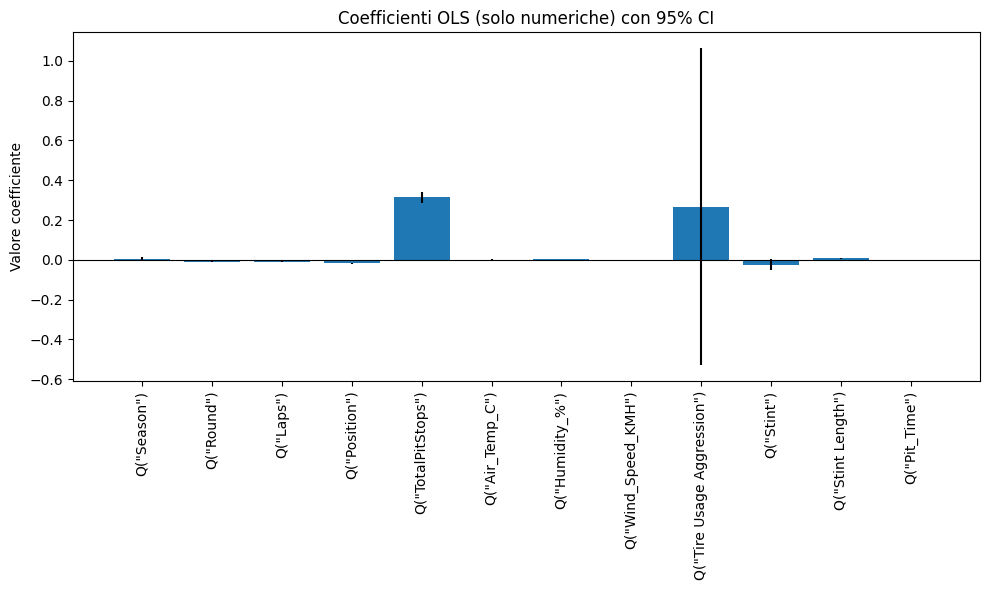

In [30]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Assicuriamoci che log_Aggression sia presente
df_reduced['log_Aggression'] = np.log1p(df_reduced['Driver Aggression Score'])

# 2) Prendo tutti i numerici tranne il target
numeric_cols = df_reduced.select_dtypes(include='number').columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['Driver Aggression Score', 'log_Aggression']]

# 3) Droppo le righe senza tutte le numeriche + target
df_num = df_reduced.dropna(subset=['log_Aggression'] + numeric_cols)

# 4) Costruisco la formula (Q() serve solo se il nome ha spazi)
rhs = ' + '.join([f'Q("{c}")' for c in numeric_cols])
formula = f'log_Aggression ~ {rhs}'
print("Formula numerica:", formula)

# 5) Fit OLS
model_num = smf.ols(formula, data=df_num).fit()
print(model_num.summary())

# 6) Plot dei coefficienti (senza l'intercept)
dfc = pd.DataFrame({
    'coef':     model_num.params,
    'ci_l':     model_num.conf_int().iloc[:,0],
    'ci_u':     model_num.conf_int().iloc[:,1],
})
dfc = dfc.drop(index='Intercept')
dfc['err'] = (dfc['ci_u'] - dfc['ci_l'])/2

plt.figure(figsize=(10,6))
plt.bar(dfc.index, dfc['coef'], yerr=dfc['err'])
plt.axhline(0, color='k', linewidth=0.8)
plt.xticks(rotation=90)
plt.title('Coefficienti OLS (solo numeriche) con 95% CI')
plt.ylabel('Valore coefficiente')
plt.tight_layout()
plt.show()



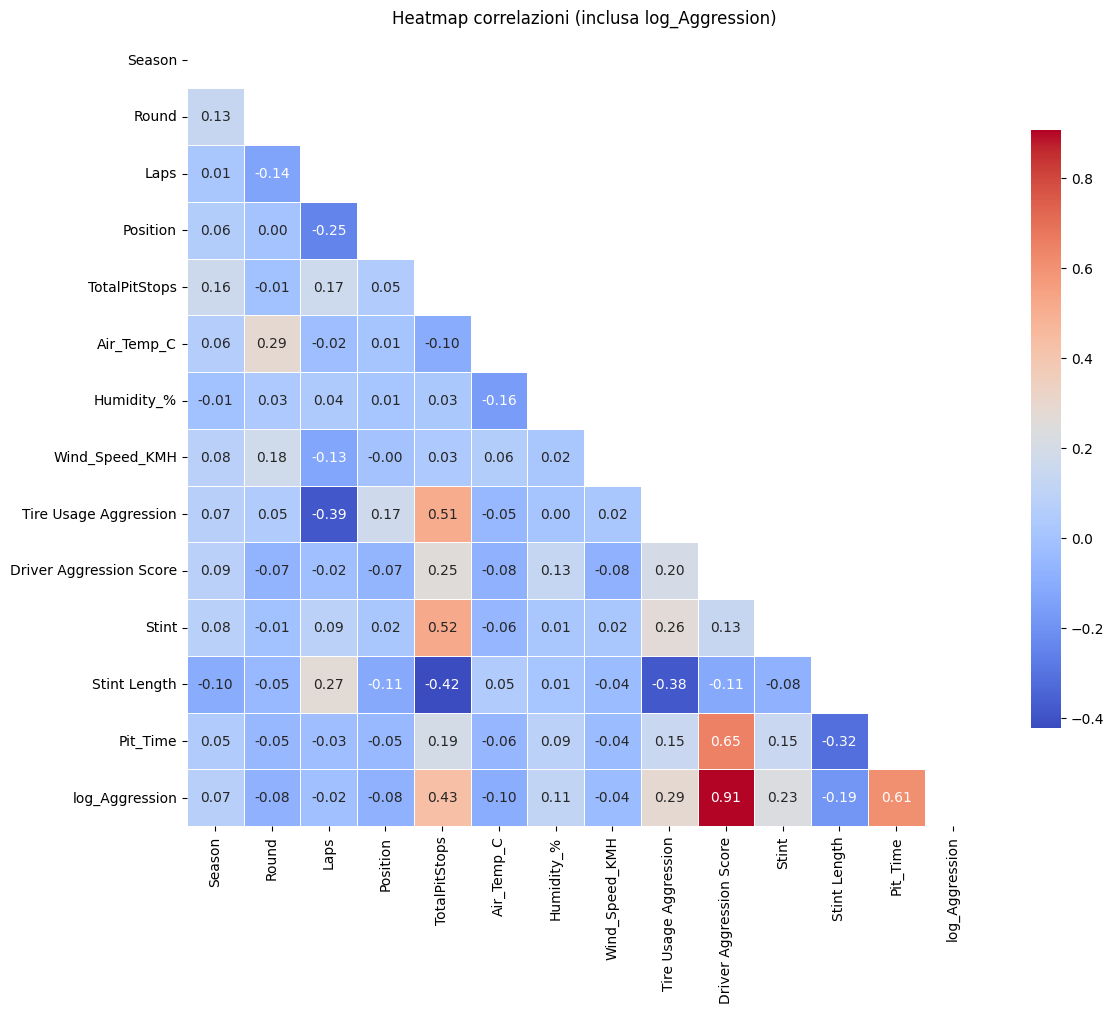

Correlazione di log_Aggression con le altre variabili numeriche:
Driver Aggression Score    0.906101
Pit_Time                   0.609262
TotalPitStops              0.431672
Tire Usage Aggression      0.288118
Stint                      0.229111
Humidity_%                 0.114240
Season                     0.073334
Laps                      -0.015632
Wind_Speed_KMH            -0.036612
Round                     -0.076023
Position                  -0.077060
Air_Temp_C                -0.098679
Stint Length              -0.187436
Name: log_Aggression, dtype: float64


In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assicurati che log_Aggression esista già
df_reduced['log_Aggression'] = np.log1p(df_reduced['Driver Aggression Score'])

# 1) Costruisci il dataset solo con le colonne numeriche
num_df = df_reduced.select_dtypes(include=[np.number])

# 2) Calcola la matrice di correlazione
corr = num_df.corr()

# 3) Heatmap triangolare superiore
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12,10))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', square=True, linewidths=.5,
            cbar_kws={"shrink": .75})
plt.title('Heatmap correlazioni (inclusa log_Aggression)')
plt.tight_layout()
plt.show()

# 4) Estrarre e ordinare le correlazioni di log_Aggression con gli altri numerici
corr_with_log = corr['log_Aggression'].drop('log_Aggression').sort_values(ascending=False)
print("Correlazione di log_Aggression con le altre variabili numeriche:")
print(corr_with_log)


In [35]:
from pygam import LinearGAM, s

# scegli 3–5 variabili numeriche chiave
X_gam = df_reduced[['Stint Length','Pit_Time','TotalPitStops']].values
y_gam = df_reduced['log_Aggression'].values

gam = LinearGAM(s(0) + s(1) + s(2)).gridsearch(X_gam, y_gam)
print("GAM R²:", gam.statistics_['pseudo_r2'])


ValueError: X data must not contain Inf nor NaN